# Unsupervied Clustering

The notebook aims at understanding the mac addresses using a clustering algorithm (k-means) to determine whether the mac addresses are stationary or moving (shoppers).

## Theory

Machine learning is the most common method for find clustering data into seperate groups.

Python has various packages to perform machine learning (out of the box) on a dataset. We have used these packages to determine whether they can seperate out devices (mac addresses) into shoppers and non-shoppers.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils

## Import data

In [4]:
mac_address_df = utils.import_mac_addresses()

In [5]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

154152 mac addresses with 18 features


In [6]:
from msci.cleaning import mac_address_features

In [7]:
signal_df = utils.import_signals()

## Investigation

In [45]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_turning_angle_velocity',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

In [46]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10].dropna(subset=FEATURE_LIST)

In [47]:
mac_address_clean_df.describe()

,frequency,radius_of_gyration,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,total_turning_angle,av_turning_angle_velocity,av_path_length,total_path_length,av_straightness,av_speed_from_total,turning_angle_density
count,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000
mean,90.699709,57.749790,2.402008,13413.549629,0.026712,0.966003,1.626512,141.177089,-0.004662,26.588731,1567.478145,2.513107,0.270036,0.072905
std,203.665588,28.075675,1.461152,18867.794012,0.161243,1.218436,0.363271,381.021519,0.189985,15.977674,2723.290050,1.231534,0.272835,0.051967
min,11.000000,0.944355,0.000000,87.000000,0.000000,0.004872,0.084186,0.390607,-3.119614,0.183925,16.185363,1.000000,0.000194,0.001430
25%,17.000000,35.941058,1.313579,2120.000000,0.000000,0.435000,1.385630,22.629754,-0.049368,15.964845,539.127871,1.818841,0.103390,0.037817
50%,38.000000,61.157028,2.130152,6058.000000,0.000000,0.623315,1.619592,48.251357,-0.000027,22.458634,1020.131638,2.266002,0.198810,0.059034
75%,85.000000,79.042536,3.214550,14044.000000,0.000000,0.971918,1.859266,114.902579,0.049170,32.954900,1716.968419,2.864555,0.335048,0.090295
max,4344.000000,154.812502,15.556349,86335.000000,1.000000,23.011323,3.141593,8561.045646,3.049002,161.696885,138837.554597,40.620109,3.969383,0.477567


We need to scale each feature into a Gaussian distribution.

In [48]:
mac_address_scaled_df = mac_address_clean_df.copy()

for feature in FEATURE_LIST:
    mac_address_scaled_df[feature] = scale(mac_address_clean_df[feature])

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [49]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

### Kmeans

This is one of the simplist clusetering methods.

Each point is defined into a distinct group with no probability given. This does not allow you to remove points which which have low uncertainty.

In [55]:
n_clusters = 2

model = KMeans(n_clusters=n_clusters)
model.fit(samples)
labels = model.predict(samples)

In [56]:
mac_address_clean_df['kmeans_label'] = labels

In [57]:
mac_address_clean_df.kmeans_label.value_counts()

0    16809
1     6252
Name: kmeans_label, dtype: int64

### Gaussian Mixture

In [58]:
samples = mac_address_clean_df.as_matrix(
    columns=FEATURE_LIST
)

In [59]:
model = BayesianGaussianMixture(n_components=2)
model.fit(samples)
labels = model.predict(samples)

In [60]:
mac_address_clean_df['gaussian_mixture_label'] = labels

In [61]:
mac_address_clean_df.gaussian_mixture_label.value_counts()

0    13804
1     9257
Name: gaussian_mixture_label, dtype: int64

## Venn Diagrams

In [62]:
k_means_non_shopper_index = mac_address_clean_df[mac_address_clean_df.kmeans_label == 1].index.tolist()
gaussian_mixturee_non_shopper_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 1].index.tolist()
out_of_hours_non_shopper_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 1].index.tolist()

In [63]:
k_means_shopper_index = mac_address_clean_df[mac_address_clean_df.kmeans_label == 0].index.tolist()
gaussian_mixturee_shopper_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 0].index.tolist()
out_of_hours_shopper_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 0].index.tolist()

Text(0.5,1,'Venn diagram of devices  \n classified as non-shoppers by 2 ML techniques')

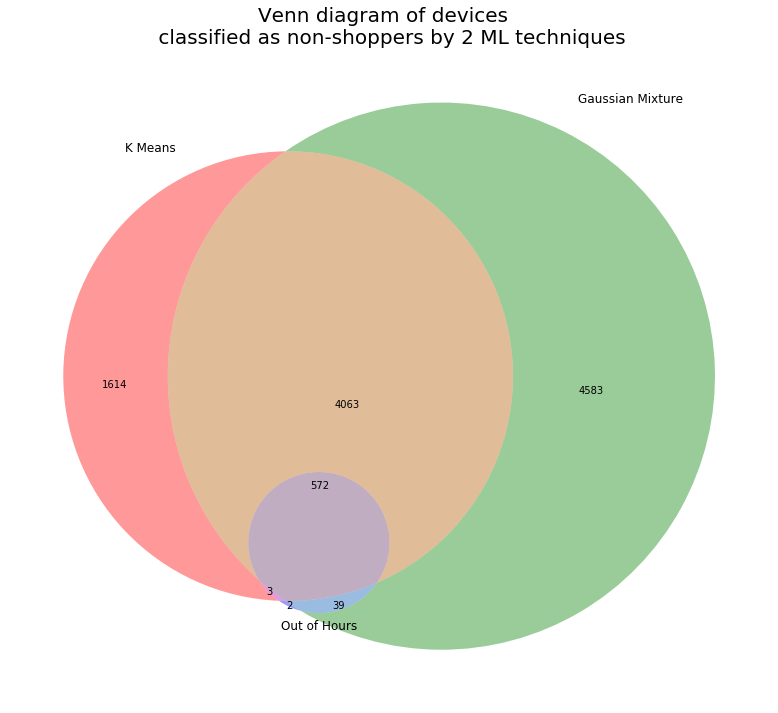

In [64]:
from matplotlib_venn import venn3

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

set1s = set(k_means_non_shopper_index)
set2s = set(gaussian_mixturee_non_shopper_index)
set3s = set(out_of_hours_non_shopper_index)

venn3([set1s, set2s, set3s], ('K Means', 'Gaussian Mixture', 'Out of Hours'), ax=ax1)
ax1.set_title('Venn diagram of devices  \n classified as non-shoppers by 2 ML techniques', fontsize=20)

Almost all of the devices that were out of hours have been classified as non-shoppers. Both clustering methods has given different result.